60000
NeuralNet(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1-5): 5 x Linear(in_features=1024, out_features=1024, bias=True)
    (6): Linear(in_features=1024, out_features=10, bias=True)
  )
  (relu): ReLU()
  (batchnorm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Epoch [1/30], Step [100/300], Loss: 0.3308100998401642
Epoch [1/30], Step [200/300], Loss: 0.30803078413009644
Epoch [1/30], Step [300/300], Loss: 0.23505574464797974
Epoch [2/30], Step [100/300], Loss: 0.11388968676328659
Epoch [2/30], Step [200/300], Loss: 0.15672363340854645
Epoch [2/30], Step [300/300], Loss: 0.08636036515235901
Epoch [3/30], Step [100/300], Loss: 0.09508656710386276
Epoch [3/30], Step [200/300], Loss: 0.07759417593479156
Epoch [3/30], Step [300/300], Loss: 0.12518839538097382
Epoch [4/30], Step [100/300], Loss: 0.033137597143650055
Epoch [4/30], Step [200/300], Loss: 0.038504213094711304
Epoch [4/30], Step [300/300

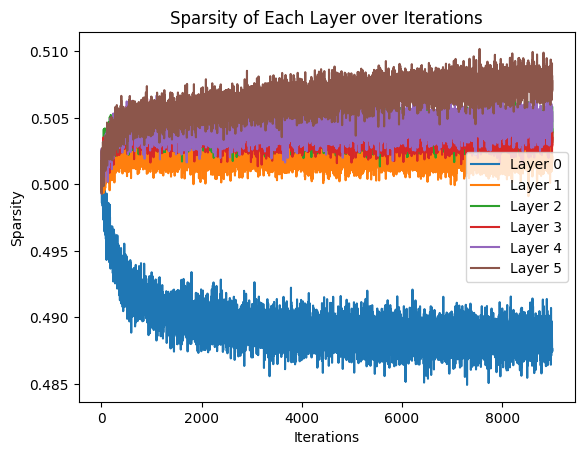

Accuracy of the network on the 10000 test images: 96.89 %


In [36]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 定义神经网络模型
device=torch.device(device='cuda' if torch.cuda.is_available() else 'cpu')

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, ini_bias):
        super(NeuralNet, self).__init__()
        linear_with_bias = nn.Linear(input_size, hidden_size, bias=True)
        nn.init.constant_(linear_with_bias.bias, ini_bias)
        nn.init.kaiming_normal_(linear_with_bias.weight, mode='fan_in')
        self.layers = nn.ModuleList([linear_with_bias])
        for _ in range(num_layers-1):
            hidden_with_bias = nn.Linear(hidden_size, hidden_size, bias=True)
            nn.init.constant_(hidden_with_bias.bias, ini_bias)
            nn.init.kaiming_normal_(linear_with_bias.weight, mode='fan_in')
            self.layers.append(hidden_with_bias)

        self.layers.append(nn.Linear(hidden_size, num_classes))
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.batchnorm(self.relu(layer(x)))
        x = self.layers[-1](x)
        return x


# 超参数设置
input_size = 784  # MNIST 图像大小为 28x28，展平后为 784
hidden_size = 1024  # 隐藏层大小
num_layers = 6  # 线性层数量
num_classes = 10  # 类别数
num_epochs = 30
batch_size = 200
learning_rate = 5e-3
ini_bias = -0

# 加载 MNIST 数据集
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transforms.ToTensor())

print(len(train_dataset))

# 数据加载器
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size, shuffle=False)

# 定义模型、损失函数和优化器
model = NeuralNet(input_size, hidden_size, num_layers, num_classes, ini_bias)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print(model)

# 训练模型
total_step = len(train_loader)
layer_outputs = [[] for _ in range(num_layers)]
for epoch in range(num_epochs):

    for i, (images, labels) in enumerate(train_loader):
        images,labels = images.to(device), labels.to(device)
        images = images.reshape(-1, 28*28)

        # 前向传播和计算损失
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item()}')

        for j in range(num_layers):
            images_ac = torch.relu(model.layers[j](images))
            batch_norm_layer = nn.BatchNorm1d(hidden_size).to(device)
            images = batch_norm_layer(images_ac)
            zero_count = (images_ac == 0).sum().item()  # 激活函数后为0的个数
            total_count = images.numel()  # 总元素数
            zero_ratio = zero_count / total_count  # 计算比例
            layer_outputs[j].append(zero_ratio)

# 可视化结果
iter = range(len(layer_outputs[0]))
for row in range(len(layer_outputs)):
    plt.plot(iter, layer_outputs[row][:], label=f"Layer {row}")

plt.xlabel("Iterations")
plt.ylabel("Sparsity")
plt.title("Sparsity of Each Layer over Iterations")
plt.legend()
plt.show()


# 测试模型
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(
        100 * correct / total))